<a href="https://colab.research.google.com/github/probml/pgm-jax/blob/main/gaussian-bp/gauss-bp-1d-line.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [88]:
import numpy as np

from jax import numpy as jnp
from jax import random as jr
from jax import jit
from matplotlib import pyplot as plt

# Demo

In [90]:
from gauss_bp.gauss_factor_graph import (CanonicalPotential, GaussianVariableNode, CanonicalFactor,
                                        GaussianFactorGraph, make_canonical_factor, make_factor_graph,
                                        init_messages, update_all_messages, calculate_all_beliefs)

In [91]:
def cpot_to_moment_1D(cpot):
    eta, Lambda = cpot
    var = 1/Lambda.squeeze()
    return eta * var, var

def beliefs_to_means_covs(beliefs):
    mean_var_list = [cpot_to_moment_1D(b) for b in beliefs.values()]
    means, variances = (jnp.hstack(x) for x in zip(*mean_var_list))
    return means, variances

def plot_beliefs(fg,messages,xs=None,**kwargs):
    beliefs = calculate_all_beliefs(fg,messages)
    mus, covs = beliefs_to_means_covs(beliefs)
    if xs is None:
        xs = np.arange(len(mus))
    if 'fmt' not in kwargs:
        kwargs['fmt'] = "-o"
    plt.errorbar(xs, mus, yerr=np.sqrt(covs), **kwargs); 

### Define measurement factors

In [92]:
def gamma(x,g1,g2):
    return (g1-x)/(g1-g2)

def measurement_pot(meas,g1,g2,delta=1.):
    mx, my = meas
    γ = gamma(mx,g1,g2)
    eta = delta * jnp.array([(1-γ)*my, γ*my])
    Lambda = delta * jnp.array([[(1-γ)**2, γ*(1-γ)],
                                [γ*(1-γ), γ**2]])
    return CanonicalPotential(eta, Lambda)

def create_measurement_factor(meas,xs,var_nodes,delta=1.):
    mx, my = meas
    i = np.argwhere(xs > mx).min()
    mpot = measurement_pot(meas,xs[i],xs[i-1], delta)
    mfactor = make_canonical_factor(f"meas_{i}-{i-1}",(var_nodes[i],var_nodes[i-1]),mpot)
    return mfactor

### Create measurement data

In [111]:
key = jr.PRNGKey(42)
mxs = jr.randint(key, (n_measurements,), 0, x_range)
key, subkey = jr.split(key)
mys = jnp.sin(mxs) + jr.normal(key, (n_measurements,))*data_std

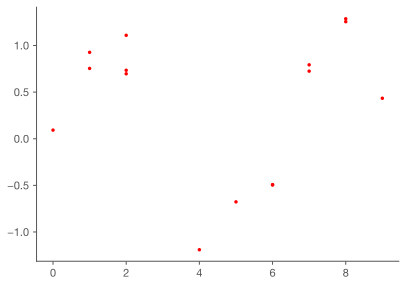

In [112]:
plt.plot(mxs,mys,'r.');

### Set Model Parameters

In [113]:
n_varnodes = 20
x_range = 10
n_measurements = 15

## Parameters ##
prior_cov = 10.
prior_prec = 1/prior_cov
data_cov = 0.05
data_prec = 1/data_cov
smooth_cov = 0.1
smooth_prec = 1/smooth_cov
data_std = jnp.sqrt(data_cov)

## Evaluation points ##
xs = jnp.linspace(0, x_range, n_varnodes)

### Construct factor graph

In [114]:
## Variable nodes ##
dim = 1
prior_Lambda = jnp.array([[prior_prec]])
var_nodes = [GaussianVariableNode(i,dim,CanonicalPotential(jnp.zeros(dim),prior_Lambda))
             for i in range(n_varnodes)]

## Smoothing factors ##
smoothing_eta = jnp.zeros(2*dim)
smoothing_Lambda = jnp.array([[smooth_prec, -smooth_prec],
                              [-smooth_prec, smooth_prec]])
smoothing_pot = CanonicalPotential(smoothing_eta, smoothing_Lambda)
smoothing_factors = [CanonicalFactor(factorID=f"smoothing_factor_{i}-{i+1}",
                           adj_varIDs=[i,i+1],
                           potential=smoothing_pot,
                           var_scopes = {i:(0,1),i+1:(1,2)})
                       for i in range(n_varnodes-1)]

## Measurement factors ##
measurement_factors = [create_measurement_factor(m,xs,var_nodes, delta=data_prec) for m in zip(mxs,mys)]

## All factors ##
factors = smoothing_factors + measurement_factors

fg = make_factor_graph(var_nodes, factors)

In [105]:
jit_update_messages = jit(lambda m: update_all_messages(fg,m))

### Plot initial belief state

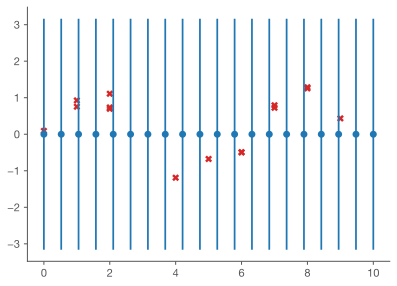

In [119]:
plt.plot(mxs,mys,'X',color="C3");
plot_beliefs(fg,init_messages(fg),xs, fmt="o")

### Loopy belief propagation

In [120]:
messages = init_messages(fg)
for _ in range(10):
    messages = jit_update_messages(messages)

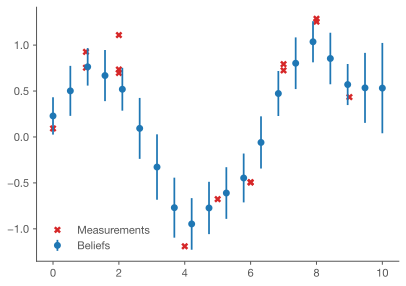

In [127]:
plt.plot(mxs,mys,'X',color="C3",label="Measurements")
plot_beliefs(fg,messages,xs, fmt="o",label="Beliefs")
plt.legend();